# IMPLEMENTACION REGRESION LOGÍSTICA.
Continuando con los datos de nuestro archivo, implementaremos una regresión logística para comprobar si el estudio de dos columnas de datos nos permiten predecir cual será el valor de una tercera. Para este ejercicio intentaremos predecir si el usuario es más dado a cancelar (is_churned) en función de su edad (age) y el número de anuncios que escucha por semana (ads_listened_per_week), habiendo considerado que son las variables para las que más fácilmente puede la empresa corregir su modelo con el objetivo de aumentar la permanencia de los usuarios.

In [54]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import math
import matplotlib.pyplot as plt


Comenzaremos por cargar los datos y seleccionar los que usaremos

In [75]:
spotify_file_path = 'spotify_churn_dataset.csv'
spotify_data = pd.read_csv(spotify_file_path, usecols=["age", "is_churned", "ads_listened_per_week"], nrows=80) #80 lineas para pruebas

X=pd.DataFrame({"v1":spotify_data["ads_listened_per_week"],"v2":spotify_data["age"]})
Y=pd.DataFrame({"cancela":spotify_data["is_churned"]})

Y la función por la cual observarlos

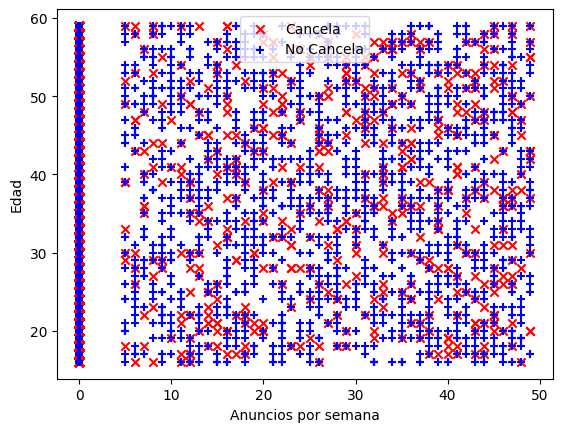

In [56]:
def plotData(data):

    cancela=data[data["is_churned"]==1]
    nocancela=data[data["is_churned"]==0]

    plt.scatter(x=cancela["ads_listened_per_week"], y=cancela["age"], c="red", marker="x", label="Cancela")
    plt.scatter(x=nocancela["ads_listened_per_week"], y=nocancela["age"],c="blue", marker="+", label="No Cancela")

    plt.xlabel("Anuncios por semana")
    plt.ylabel("Edad")
    plt.legend()
    plt.show()

plotData(spotify_data)

In [57]:
m, n = X.shape
ones=np.ones((len(X),1))
X.insert(0,"unos", ones)

initial_thetas = np.zeros((n+1,1))

Implementamos la función de sigmoide, coste y gradiente

In [58]:
def sigmoide(z):
    g=1/(1+np.exp(-z))
    return g

def coste(theta, X, y):
    m = len(y)
    J = 0
    h = sigmoide(np.dot(X,theta))
    J = (-1/m) * np.sum(np.multiply(y,np.log(h))+np.multiply(1-y,np.log(1-h)), axis=0)
    return J#.item()

def gradiente(theta, X, y):
    m = len(y)
    J = 0
    grad = np.zeros((len(theta)))
    h = sigmoide(np.dot(X,theta))
    grad = (1/m) * np.dot(X.T,(h-y))
    return grad

In [59]:
# Compute and display initial cost and gradient
vcoste=coste(initial_thetas, X, Y)
vgradiente=gradiente(initial_thetas, X, Y)

print("Coste Inicial para THETA = 0: ",vcoste)
print("Gradiente Inicial para THETA = 0: ",vgradiente)

#print(X)
#print(Y)

Coste Inicial para THETA = 0:  cancela    0.693147
dtype: float64
Gradiente Inicial para THETA = 0:  [[0.241125 ]
 [1.6879375]
 [9.0590625]]


In [60]:
print(type(coste), type(gradiente))
print(type(X), type(Y))

<class 'function'> <class 'function'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


Empleamos la función $fmin_cg$ para encontrar el mínimo de la función de coste con los parámetros $theta$. 

In [61]:
params= op.fmin_cg(maxiter=20,f=coste,x0=initial_thetas.flatten(), fprime=gradiente, args=(X,Y.to_numpy().flatten()))

print(params)

         Current function value: 0.571892
         Iterations: 20
         Function evaluations: 47
         Gradient evaluations: 44
[-1.02475034e+00 -5.83184183e-04 -4.76552245e-04]


Y la función para representar nuestra frontera de decisión

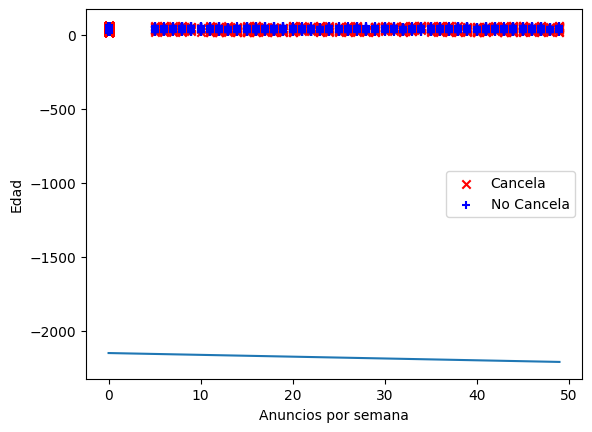

In [62]:
def plotDecisionBoundary(data, theta, X, Y):
    cancela=data[data["is_churned"]==1]
    nocancela=data[data["is_churned"]==0]

    plt.scatter(x=cancela["ads_listened_per_week"], y=cancela["age"], c="red", marker="x", label="Cancela")
    plt.scatter(x=nocancela["ads_listened_per_week"], y=nocancela["age"],c="blue", marker="+", label="No Cancela")

    plt.xlabel("Anuncios por semana")
    plt.ylabel("Edad")

    xvalues=[min(cancela["ads_listened_per_week"]),max(cancela["ads_listened_per_week"])]
    yvalues=-(theta[0]+np.dot(theta[1],xvalues))/theta[2]

    plt.plot(xvalues,yvalues)
    
    plt.legend()
    plt.show()   

plotDecisionBoundary(spotify_data,params,X,Y)


Terminadas estas tareas ya podemos empezar a predecir en base a la edad y los anuncios escuchados por semana si un usuario es más o menos probable que decidad cancelar su suscripción al servicio

In [63]:
def prediccion(theta, X_train, bool_round):

    if bool_round:

            pred= np.round(sigmoide(np.dot(X_train,theta)))
    else:
            pred=sigmoide(np.dot(X_train,theta))

    return pred

Y probamos con varios datos aleatorios el correcto funcionamiento de nuestro modelo

In [64]:
usuario1=prediccion(params, np.array([[1,45,85]]), bool_round=False) #columna de unos, anuncios,edad
print("La probabilididad de que el usuario cancele es de ", usuario1)

usuario2=prediccion(params, np.array([[1,0,35]]), bool_round=False) #columna de unos, anuncios,edad
print("La probabilididad de que el usuario cancele es de ", usuario2)

usuario3=prediccion(params, np.array([[1,100,23]]), bool_round=False) #columna de unos, anuncios,edad
print("La probabilididad de que el usuario cancele es de ", usuario3)

usuario4=prediccion(params, np.array([[1,100,56]]), bool_round=False) #columna de unos, anuncios,edad
print("La probabilididad de que el usuario cancele es de ", usuario4)

La probabilididad de que el usuario cancele es de  [0.25133582]
La probabilididad de que el usuario cancele es de  [0.26087423]
La probabilididad de que el usuario cancele es de  [0.25086026]
La probabilididad de que el usuario cancele es de  [0.24791644]


Como podemos comprobar se observa que a mayor edad y anuncios por semana mayor es la probabilidad de cancelación del servicio, siendo los anuncios por semana el parametro más influyente.

La interpretación de interés para la compañía sería que, en vistas a aumentar la permanencia de los usuarios, deberían, si no reducir los anuncios que les hacen escuchar, tomar la medida de redirigirlos al público de edad más avanzada, que es menos dado a cancelar por ello.

In [65]:
from random import randrange
from sklearn.model_selection import train_test_split
from sklearn import metrics

Preparamos la elaboración del metodo holdout para dividir el dataset en los grupos de prueba y entrenamiento.

In [66]:
def y_change(y, cl):
    y_pr=[]
    for i in range(0, len(y)):
        if y.iloc[i,0] == cl:
            y_pr.append(1)
        else:
            y_pr.append(0)
    y_new = pd.DataFrame({'label':y_pr})
    return y_new

In [67]:
def training(initial_theta, X_train, y_train, num_clases):
  all_theta = []
  all_cost = []
  all_class = []

  for current_class in range(1, num_clases+1):
      res_optimization = op.fmin_cg(maxiter=20,f=coste,x0=initial_thetas.flatten(), fprime=gradiente, args=(X_train,y_train.to_numpy().flatten()), 
                             full_output = True)

      all_theta.append(res_optimization[0])
      all_cost.append(res_optimization[1])
      all_class.append(current_class)
    
  df_opt = pd.DataFrame({'class':all_class, 'theta':all_theta, 'cost':all_cost})
  
  return df_opt

In [68]:
def predict(res_optimization, X):
  m = len(X)
  all_instances = []
  all_predictions = []

  for i in range(0, len(X)):
    all_h = []
  
    for current_class in res_optimization['class']:
      h = sigmoide(np.dot(X,initial_thetas))
      all_h.append(h)
    
    pred = np.argmax(all_h)+1
    all_predictions.append(pred)
    all_instances.append(i)
  
  return pd.DataFrame({'instance':all_instances, 'prediction':all_predictions})

In [69]:
def holdout(X, y, percentage=0.6):
  index_training = []
  while len(index_training) < round(percentage*len(X)):
    random_index = randrange(len(X))
    if random_index not in index_training:
      index_training.append(random_index)

  X_training = X.iloc[index_training]
  y_training = y.iloc[index_training]
  X_test = X.iloc[~X.index.isin(index_training)]
  y_test = y.iloc[~y.index.isin(index_training)]
  print("El tamaño del training debe ser: ", round(percentage*len(X)), " - Comprobación: tamaño X_training es ", len(X_training), " y tamaño y_training es", len(y_training))
  print("El tamaño del test debe ser: ", len(X)-round(percentage*len(X)), " - Comprobación: tamaño X_test es ", len(X_test), " y tamaño y_test es", len(y_test))
  
  X_training = X_training.reset_index(drop=True)
  y_training = y_training.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)
  y_test = y_test.reset_index(drop=True)
  
  return X_training, y_training, X_test, y_test

X_training, y_training, X_test, y_test = holdout(X, Y, 0.7)

El tamaño del training debe ser:  5600  - Comprobación: tamaño X_training es  5600  y tamaño y_training es 5600
El tamaño del test debe ser:  2400  - Comprobación: tamaño X_test es  2400  y tamaño y_test es 2400


In [71]:
num_classes = 2
initial_theta = np.zeros((X.shape[1],1))
X_training, y_training, X_test, y_test = holdout(X, Y, 0.7)
res_optimization_training = training(initial_theta, X_training, y_training, num_classes)

El tamaño del training debe ser:  5600  - Comprobación: tamaño X_training es  5600  y tamaño y_training es 5600
El tamaño del test debe ser:  2400  - Comprobación: tamaño X_test es  2400  y tamaño y_test es 2400
         Current function value: 0.571512
         Iterations: 20
         Function evaluations: 56
         Gradient evaluations: 53
         Current function value: 0.571512
         Iterations: 20
         Function evaluations: 56
         Gradient evaluations: 53


In [74]:
res_prediction_test = training(initial_theta, X_test, y_test, num_classes)
accuracy_test = predict(res_prediction_test, X)
print("Test accuracy: ", accuracy_test)

         Current function value: 0.572323
         Iterations: 20
         Function evaluations: 48
         Gradient evaluations: 45
         Current function value: 0.572323
         Iterations: 20
         Function evaluations: 48
         Gradient evaluations: 45
Test accuracy:        instance  prediction
0            0           1
1            1           1
2            2           1
3            3           1
4            4           1
...        ...         ...
7995      7995           1
7996      7996           1
7997      7997           1
7998      7998           1
7999      7999           1

[8000 rows x 2 columns]
